## Projekt 2 - Uczenie nienadzorowane (Podstawy uczenia maszynowego)

### Remigiusz Drobinski

Każdy piksel obrazu RGB zawiera po jednej wartości dla każdego z 3 kanałów: R (red), G (green) i B (blue). Korzystając z grupowania metodą k-średnich, możemy podzielić wszystkie piksele danego obrazu na k klastrów i każdemu pikselowi przypisać kolor reprezentowany przez najbliższego centroida (tj. środek ciężkości grupy, do której dany piksel został przydzielony). Dzięki temu działaniu obraz składający się z milionów kolorów może zostać skompresowany do obrazu zawierającego jedynie k kolorów.


In [2]:
import numpy as np #tablice
import pandas as pd #printDesign
import matplotlib.pyplot as plt #wykresy
from PIL import Image #import pliku
from sklearn.cluster import KMeans #kmeans
from sklearn.decomposition import PCA #pca

### 1. Wczytać obraz 'spring.png' (np. za pomocą biblioteki PIL) i potraktować każdy piksel jako pojedynczy punkt o 3 wymiarach. 

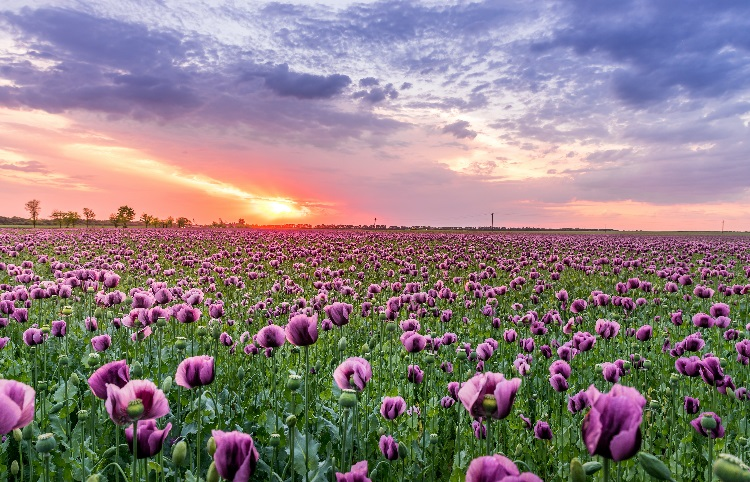

In [3]:
 #import grafiki
filename = 'spring.png'
img = Image.open(filename)

# pobieranie wymiarów do zmiennych
width, height = img.size

# sprawdzanie poprawności wczytania grafiki
img

In [4]:
# tablica, która będzie przechowywać tablicę z wartościami RGB dla każdego pixela
pixels = []

# pobranie wartości RGB i dołączenie do tablicy
for w in range(0, width):
    for h in range(0, height):
        pixels.append(img.getpixel((w, h)))

# sprawdzanie poprawności wczytania wartości
print(pd.DataFrame(pixels, columns=['R', 'G', 'B']))

          R    G    B
0       209  209  233
1       207  207  231
2       210  208  230
3       212  210  232
4       212  210  231
...     ...  ...  ...
361495   72  109   68
361496   51   85   48
361497   40   71   40
361498   38   62   40
361499   40   58   42

[361500 rows x 3 columns]


In [5]:
# konwersja
pixels = np.array([np.array(xi) for xi in pixels])
print(pixels)

[[209 209 233]
 [207 207 231]
 [210 208 230]
 ...
 [ 40  71  40]
 [ 38  62  40]
 [ 40  58  42]]


### 2. Dokonać klasteryzacji metodą k-średnich i wybrać do ostatecznego podziału jako liczbę k najmniejszą z liczb, dla której wartość inercji jest mniejsza niż  3*10^{8} . 

In [6]:
# funkcja odpowiedzialna za kmeans
# pobieranie tablicy tablic z wartościami RGB

def k_means(data):
    # models - przechowuje modele kmeans
    # inertia - przechowuje wartości inercji 
    models = []
    inertia = []
      
    # pętla do 15 włącznie na podstawie podpowiedzi
    for i in range(1, 16):
        # kmeans
        kmeans = KMeans(n_clusters=i, random_state=1, init='k-means++', max_iter=100)
        kmeans = kmeans.fit(data)
        # dołączenie wartości do odpowiedniej tablicy
        models.append(kmeans)
        inertia.append(kmeans.inertia_)
    
    # zwracanie tablicę modeli oraz inercji
    return models, inertia

In [7]:
# zmienne, które przechowują zwracane wartości tablic dla wcześniejszej bazy wartości RGB
res_models, res_inertia = k_means(pixels)

In [8]:
# sprawdzanie poprawności wartości inercji (z podpowiedzi wynika że powinny oscylować w okolicach 3*pow(10,8))
res_inertia

[4606131629.11032,
 1465957184.3213508,
 959706829.3703226,
 727689532.2847146,
 626584098.5444813,
 542745066.5505276,
 471311266.91843224,
 416423200.7018984,
 372260747.6652648,
 339772986.01367396,
 308171927.9678043,
 284891186.31051,
 264654830.09996626,
 246972392.7195811,
 231172730.55595282]

In [9]:
# przyjemniejsze dla oka wyświetlanie wartości inercji
cluster_amounts = [i.n_clusters for i in res_models]
pd.DataFrame([res_inertia], index=["Wartość inercji"], columns=[cluster_amounts]).T

,Wartość inercji
1,4.606132e+09
2,1.465957e+09
3,9.597068e+08
4,7.276895e+08
5,6.265841e+08
6,5.427451e+08
7,4.713113e+08
8,4.164232e+08
9,3.722607e+08
10,3.397730e+08


In [20]:
# konwersja
res_inertia = np.array(res_inertia)

# znajdowanie największej wartości inercji mniejszej niż 3 * pow(10,8)
res_value = res_inertia[res_inertia < 3 * 10**8][0]

# zwracanie odpowiedniego modelu
res_index = list(res_inertia).index(res_value)
res_best_model = res_models[res_index]

# informacja odnośnie wybranego modelu
res_best_model

KMeans(max_iter=100, n_clusters=12, random_state=1)

### 3. Współrzędne wszystkich uzyskanych centroidów zaokrąglić do najbliższej liczby całkowitej. 

In [22]:
# centra klastrów wybranego modelu
res_centers = res_best_model.cluster_centers_

# zaokrąglanie wartości
for i in range(len(res_centers)): 
    res_centers[i] = [round(j) for j in res_centers[i]]
    
# wyświetlanie centrów
print(res_centers)

[[139.  75. 102.]
 [207. 162. 180.]
 [ 85.  35.  58.]
 [ 52.  78.  30.]
 [168. 166. 202.]
 [121. 124. 181.]
 [230. 211. 216.]
 [249. 174. 154.]
 [ 89. 108.  63.]
 [176. 118. 155.]
 [129. 146. 105.]
 [ 23.  31.  11.]]


### 4. Dla grupowania na tak ustalone k klastrów dokonać przypisania każdemu pikselowi jego zaokrąglonej wartości środka ciężkości. 

In [26]:
# tablica pixeli, która będzie przechowywać nowe wartości RGB pixeli
newPixels = pixels.copy()

# pobranie wartości odpowiedniego klastra danego pixelu
for i in range(len(newPixels)):
    newPixels[i] = centroids[res_best_model.labels_[i]]
    
newPixels = newPixels.reshape(width, height, 3)

# sprawdzanie poprawności przypisania wartości RGB konkretnego pixela
print(newPixels)

# nałożenie wartości RGB na grafice
for w in range(0, width):
    for h in range(0, height):
        img.putpixel((w, h), (newPixels[w, h, 0], newPixels[w, h, 1], newPixels[w, h, 2]))


[[[230 211 216]
  [230 211 216]
  [230 211 216]
  ...
  [ 23  31  11]
  [ 52  78  30]
  [ 52  78  30]]

 [[230 211 216]
  [230 211 216]
  [230 211 216]
  ...
  [ 52  78  30]
  [ 52  78  30]
  [ 52  78  30]]

 [[230 211 216]
  [230 211 216]
  [230 211 216]
  ...
  [ 52  78  30]
  [ 52  78  30]
  [ 52  78  30]]

 ...

 [[121 124 181]
  [121 124 181]
  [121 124 181]
  ...
  [ 52  78  30]
  [ 52  78  30]
  [ 52  78  30]]

 [[121 124 181]
  [121 124 181]
  [121 124 181]
  ...
  [ 52  78  30]
  [ 52  78  30]
  [ 52  78  30]]

 [[121 124 181]
  [121 124 181]
  [121 124 181]
  ...
  [ 52  78  30]
  [ 52  78  30]
  [ 52  78  30]]]


### 5. Tak utworzony obraz zapisać w pliku .png i dołączyć go do rozwiązania. 

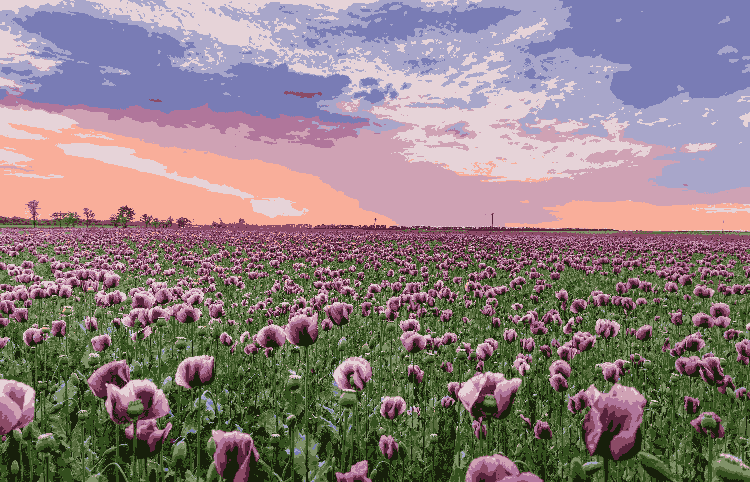

In [28]:
# demonstracja powstałej grafiki
img

In [29]:
# zapis grafiki
img.save("newSpring.png")

### 6. Przy pomocy analizy składowych głównych (PCA) dokonać redukcji wymiarowości oryginalnego obrazu 'spring.png' do 2 najważniejszych składowych głównych. Wypisać łączny procent wyjaśnionej przez nie wariancji. 

In [38]:
# pca do 2 składowych

pca = PCA(n_components=2)
principalComponents = pca.fit_transform(pixels)

# pokryty procent wariancji
print(f'Wariancja pokryła łącznie {(pca.explained_variance_ratio_[0]+pca.explained_variance_ratio_[1])*100.0:.2f}%.')

Wariancja pokryła łącznie 95.61%.


### 7. Wykonać wykres punktowy obrazu po transformacji PCA na 2 składowe. Kolor danego punktu na wykresie ma odpowiadać jego przyporządkowaniu przez wcześniej wykonane grupowanie metodą k-średnich. Utworzyć legendę, która będzie przypisywała danemu kolorowi z wykresu kolor z przyporządkowania metodą k-średnich (np. kolor niebieski to klaster 1 z metody k-średnich, kolor zielony to klaster 2 z metody k-średnich, itd.). Do legendy użyć mapy kolorów, która pozwoli na ich czytelne odróżnienie, np. ‘Paired’, tj. dodać argument cmap=plt.get_cmap(‘Paired’). Legenda nie ma zasłaniać wyświetlanych punktów. 

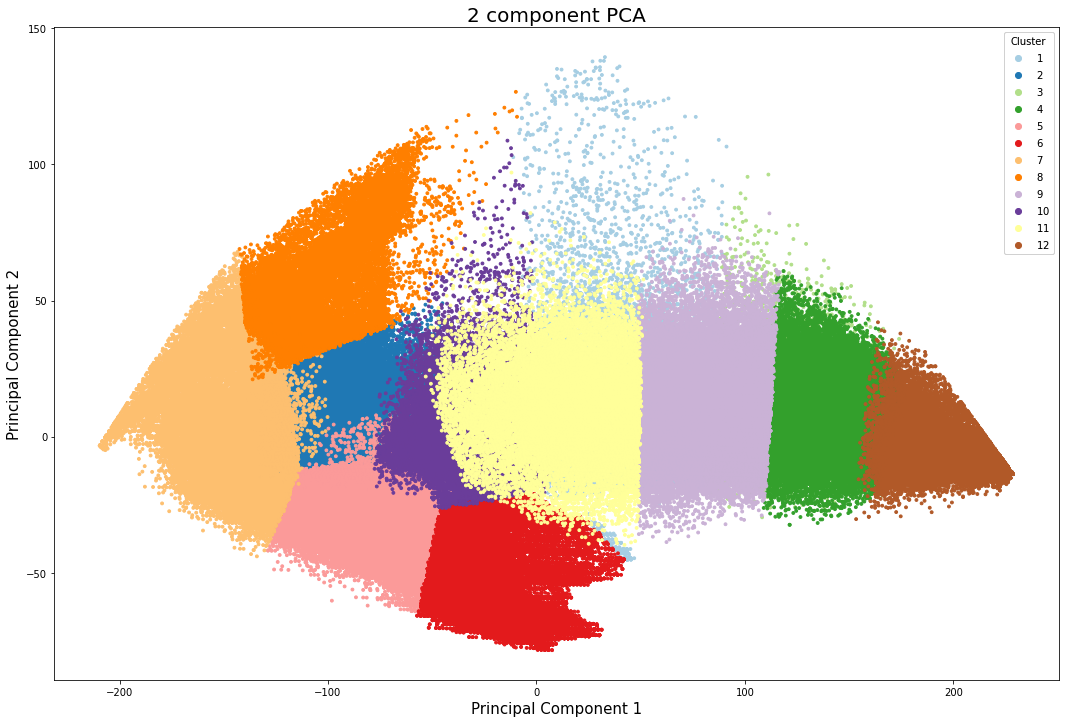

In [53]:
# zmiana zakresu [0;11] na [1,12]
clusters = res_best_model.labels_ + 1

# utworzenie tablicy, której elementy zawierają kolejno
# przypisany klaster, dwie wartości składowych z pca
data = np.concatenate((clusters.reshape(-1, 1), principalComponents), axis=1)

# posortowanie klastrami
data = data[data[:, 0].argsort()]

# tablice z wartościami poszczególnych składowych
PC1 = data[:, 1]
PC2 = data[:, 2]

PCLabels = data[:, 0]

# stworzenie subplotu oraz ustawienie wymiarów wykresu
_, ax = plt.subplots(figsize=(18,12))

# stworzenie wykresu punktowego
points = ax.scatter(
    PC1, 
    PC2, 
    c=PCLabels, 
    cmap=plt.get_cmap('Paired'), 
    label=PCLabels, 
    s=8)

# legenda
legend = ax.legend(
    *points.legend_elements(), 
    title='Cluster', 
    loc='upper right')

ax.add_artist(legend)

# ustawienie nazw osi oraz nadanie tytułu wykresowi
ax.set_xlabel(
    'Principal Component 1',
    fontsize=15)
ax.set_ylabel(
    'Principal Component 2', 
    fontsize=15)
ax.set_title(
    '2 component PCA', 
    fontsize=20)

# wyświetlanie wykresu
plt.show()